In [1]:
import numpy as np
import pandas as pd
from src2.data_loader import *
# from src.strategy import *
from src2.index import *
from src2.strategy2 import *
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score,  classification_report
from fredapi import Fred
from keras.callbacks import EarlyStopping , ModelCheckpoint

from keras.models import Sequential # deep learning model
from keras.layers import LSTM, Dropout, Dense, Activation, GRU, Flatten
from keras import optimizers # 옵티마이저 

import datetime
import tensorflow as tf
import pandas_datareader as pdr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = DataGenerator(data_type='db').data_search(ticker='AAPL')
data.sort_index(ascending=True, inplace=True)
data3 = data.copy()
data3.sort_index(ascending=True, inplace=True)

기존 데이터 불러오기 성공


In [3]:
data.columns = ["open","high","low","close","adjClose","volume"]

In [4]:
# data = data.loc["2010-09-16":"2022-10-11"]
# news = pd.read_csv("./BAC.csv", index_col=0)
# news = news[["label"]]
# news.index.rename("Datetime", inplace=True)
# data["label"] = news["label"]
# data.fillna(method="ffill", inplace=True)

In [5]:
data.columns

Index(['open', 'high', 'low', 'close', 'adjClose', 'volume'], dtype='object')

In [6]:
def add_feature(df, **kwargs):
    
    fred = Fred(api_key='d929757b1ad9cd1d5115620a50badb0a')
    
    data = df.copy()

    data["Log_Close"]                              = np.log(data["adjClose"])
    data["AC_pct"]                                 = data['adjClose'].pct_change()
    data["V_pct"]                                  = data['volume'].pct_change()
    data["sma(5)"]                                 = sma(data, 5)
    data["sma(20)"]                                = sma(data, 20)
    data["High_Yield"]                             = fred.get_series('BAMLH0A0HYM2', data.index[0]).fillna(method="ffill")
    data["volume_sma5"]                            = data["volume"].rolling(5).mean()
    data["volume_sma20"]                           = data["volume"].rolling(20).mean()
    data["T10Y2Y"]                                 = fred.get_series('T10Y2Y', data.index[0])
    data["VIX"]                                    = fred.get_series('VIXCLS', data.index[0])
    data["RSI"]                                    = rsi(data, **kwargs)
    data[["macd","macd_signal","macd_oscillator"]] = macd(data, **kwargs)
#-------------------------------------------------------------------------------------------------------------------------------------------
    
    OBV = []
    OBV.append(0)
    for i in range(1, len(data['adjClose'])):
        if data['adjClose'][i] > data['adjClose'][i-1]: 
            OBV.append(OBV[-1] + data['volume'][i]) 
        elif data['adjClose'][i] < data['adjClose'][i-1]:
            OBV.append( OBV[-1] - data['volume'][i])
        else:
         OBV.append(OBV[-1])
    data['OBV'] = OBV
    data["OBV_mv20"] = data["OBV"].rolling(20).mean()
    
    #-------------------------------------------------------------------------------------------------------------------------------------------
    
    # signal = []
    # for idx in range(len(data['adjClose'])):
    #     if idx == 0 or idx+1 == len(data['adjClose']):
    #         signal.append(0)   
    #     else:
    #         if data['adjClose'].iloc[idx-1]> data['adjClose'].iloc[idx] and data['adjClose'].iloc[idx+1]> data['adjClose'].iloc[idx]:
    #             signal.append(1) #----- 상승
    #         elif data['adjClose'].iloc[idx-1]< data['adjClose'].iloc[idx] and data['adjClose'].iloc[idx+1]< data['adjClose'].iloc[idx]:
    #             signal.append(-1) #----- 하락
    #         else:
    #             signal.append(0) #----- 횡보추세
    # data['trend'] = signal

    # data["diff"] = data["Log_Close"].diff()
    # data["trend"] = [1 if data.iloc[i]["diff"] > 0 else 0 for i in range(len(data))]

    
        
    
    # -------------------------------------------------------------------------------------------------------------------------------------------
    
    # data['r_signal']    = [-1 if data.iloc[i]['RSI'] > 70 else 1 if data.iloc[i]['RSI'] < 30 else 0 for i in range(len(data))] 
    # data['m_signal']    = [-1 if data.iloc[i]['macd'] < data.iloc[i]['macd_signal'] else 1 if data.iloc[i]['macd'] > data.iloc[i]['macd_signal'] else 0 for i in range(len(data))] 


    # sma_signal = []
    # for i in range(len(data["adjClose"])):
    #     if data.iloc[i]["sma(5)"] < data.iloc[i]["adjClose"] and data.iloc[i-1]["sma(5)"] > data.iloc[i-1]["adjClose"]:
    #         sma_signal.append(1)
    #     elif data.iloc[i]["sma(5)"] > data.iloc[i]["adjClose"] and data.iloc[i-1]["sma(5)"] < data.iloc[i-1]["adjClose"]:
    #         sma_signal.append(-1)
    #     else:
    #         sma_signal.append(0)
    # data["sma_signal"] = sma_signal
    data["signal"] =  [  1 if data["adjClose"].diff(1).iloc[i]>0 and data["adjClose"].diff(-1).iloc[i]>0
                                else -1 if data["adjClose"].diff(1).iloc[i]<0 and data["adjClose"].diff(-1).iloc[i]<0
                                else 0 for i in range(len(data))]

    # #-------------------------------------------------------------------------------------------------------------------------------------------
    
    target = []
    for i in range(1, len(data)+1):
        target.append(data.iloc[i-1:i, -1:].values.sum())
    data['tt'] = target

    data['position'] = 0
    data['position'].mask(data['tt'] >= 1, 'buy', inplace=True)
    data['position'].mask(data['tt'] == 0, 'hold', inplace=True)
    data['position'].mask(data['tt'] <= -1, 'sell', inplace=True)

    data['position'].mask(data['position'] == 'hold', 0, inplace=True)  # 0은 hold
    data['position'].mask(data['position'] == 'buy', 1, inplace=True)   # 1은 매수 
    data['position'].mask(data['position'] == 'sell', 2, inplace=True)  # 2는 매도
    data['position'] = data['position'].astype('int')

    #-------------------------------------------------------------------------------------------------------------------------------------------
    
    data.dropna(axis=0, inplace=True)
    # data.drop(["open","high","low","close","adjClose","tt","m_signal","r_signal","trend","macd_oscillator","macd_signal","volume_sma5","sma_signal","OBV"], axis=1, inplace=True)
    # data.drop(["Open","High","Low","Close","volume_sma5","macd_oscillator","macd_signal","Log_Close"], axis=1, inplace=True)
    data.drop(["tt"], axis=1, inplace=True)
    return data

In [7]:
data.columns

Index(['open', 'high', 'low', 'close', 'adjClose', 'volume'], dtype='object')

In [8]:
data = add_feature(data)

In [9]:
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

In [10]:
# 타겟값 분리
X = data.drop('position', axis=1)
y = data[['position']]

In [11]:
# 스탠다드 스케일러 사용 단, 타겟값은 적용하지 않음
ms = MinMaxScaler()
X  = ms.fit_transform(X)

In [12]:
X = pd.DataFrame(X, columns=data.columns[:-1], index=data.index)

In [13]:
# # 학습비율
# train_size = int(len(X) * 0.85)
# X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
# y_train, y_test = y.iloc[:train_size, :], y.iloc[train_size:, :]

In [14]:
X_train, X_test = X.iloc[:-48, :], X.iloc[-48:, :]
y_train, y_test = y.iloc[:-48, :], y.iloc[-48:, :]

In [15]:
X_test.shape

(48, 26)

In [16]:
# 강사님의 윈도우 코드 복붙(이건 우리 입맛에 나중에 바꿔도 상관없음)
def my_window_data(feature,target, window_size=20):
    data = pd.concat([feature,target], axis = 1)
    X_list = []
    y_list = []
    for i in range(len(data) - window_size-1):
        X = data.iloc[i:i+window_size]
        y = target.iloc[i+window_size]
        X_list.append(np.array(X))      #[[] ,[] ,[] ,[]]
        y_list.append(np.array(y))       #[]   
    return  np.array(X_list), np.array(y_list)

In [17]:
X_train, y_train = my_window_data(X_train, y_train)
X_test , y_test = my_window_data(X_test , y_test)

In [18]:
X_train.shape, y_train.shape

((6393, 20, 27), (6393, 1))

In [19]:
X_test.shape, y_test.shape

((27, 20, 27), (27, 1))


# 모델

## LSTM

In [20]:
BATCH = 20
EPOCH = 100

In [21]:
model_path = f'./model_2021/LSTM.h5'
checkpoint = ModelCheckpoint(filepath=model_path ,
                             monitor='val_accuracy',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

early_stopping = EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                              patience=20,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

In [22]:
with tf.device("/gpu:0"):
    model_LSTM = Sequential()                                     # window_size,  features
    model_LSTM.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) 
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(LSTM(64, return_sequences=False))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(units=3 , activation='softmax')) 
                 #--------------- 멀티분류

    adam = optimizers.Adam(lr = 0.001) # Learning Rate 학습속도

    model_LSTM.compile(optimizer=adam, loss='sparse_categorical_crossentropy',    #------출력층을  3개의 0,1,2 관망매도매수 구간 
                                                        #------ sparse_categorical_crossentropy , 원한인코딩안해도됨 정수그대로 ,  
                                                        # integer type 클래스 -> one-hot encoding하지 않고 정수 형태로 label(y)을 넣어줌
    metrics=['accuracy'])                     

    print(model_LSTM.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 50)            15600     
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 45,235
Trainable params: 45,235
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
hist_LSTM = model_LSTM.fit(X_train, y_train
                  , batch_size= BATCH
                  , epochs= EPOCH # 
                  , validation_data=(X_test, y_test)
                  , callbacks= [checkpoint, early_stopping]
                 )

history_LSTM = model_LSTM.evaluate(X_test, y_test)

Epoch 1/100
315/320 [============================>.] - ETA: 0s - loss: 1.0240 - accuracy: 0.4660
Epoch 1: val_accuracy improved from -inf to 0.55556, saving model to ./model_2021\LSTM.h5
320/320 [==============================] - 7s 9ms/step - loss: 1.0227 - accuracy: 0.4677 - val_loss: 0.9076 - val_accuracy: 0.5556
Epoch 2/100
317/320 [============================>.] - ETA: 0s - loss: 0.9494 - accuracy: 0.5319
Epoch 2: val_accuracy improved from 0.55556 to 0.62963, saving model to ./model_2021\LSTM.h5
320/320 [==============================] - 2s 7ms/step - loss: 0.9496 - accuracy: 0.5315 - val_loss: 0.8785 - val_accuracy: 0.6296
Epoch 3/100
318/320 [============================>.] - ETA: 0s - loss: 0.9180 - accuracy: 0.5552
Epoch 3: val_accuracy did not improve from 0.62963
320/320 [==============================] - 2s 6ms/step - loss: 0.9179 - accuracy: 0.5556 - val_loss: 0.8366 - val_accuracy: 0.6296
Epoch 4/100
314/320 [============================>.] - ETA: 0s - loss: 0.8917 - ac

In [24]:
# plt.style.use("grayscale")
# plt.figure(figsize=(20,10))
# plt.plot(hist_LSTM.history["loss"], label="train_loss", color='b', marker='o')
# plt.plot(hist.history["val_loss"], label="val_loss", color='k', marker='o')
# plt.plot(hist.history["accuracy"], label="train_acc", color='r', marker='o')
# plt.plot(hist.history["val_accuracy"], label="val_acc", color='g', marker='o')
# plt.title("Training Loss and Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="upper right")


In [25]:
pred = model_LSTM.predict(X_test)
print(pred)
pp_LSTM = np.argmax(pred, axis=-1)
pp_LSTM.shape, y_test.shape

1/1 [==============================] - 0s 351ms/step
[[6.75526336e-02 6.26778677e-02 8.69769514e-01]
 [4.01469648e-01 3.47334445e-01 2.51195908e-01]
 [1.37049943e-01 1.03453867e-01 7.59496212e-01]
 [4.39486325e-01 9.41581726e-02 4.66355473e-01]
 [3.08929741e-01 6.83691129e-02 6.22701108e-01]
 [9.07524750e-02 1.17154188e-01 7.92093396e-01]
 [3.09739619e-01 7.15924352e-02 6.18667960e-01]
 [2.67280757e-01 1.25340670e-01 6.07378602e-01]
 [3.81153226e-01 5.23815632e-01 9.50310901e-02]
 [1.44240767e-01 8.47603083e-01 8.15622881e-03]
 [3.81201953e-02 9.61406171e-01 4.73716442e-04]
 [4.20833081e-01 5.55061042e-01 2.41058413e-02]
 [1.84864730e-01 8.08318734e-01 6.81655807e-03]
 [1.35828987e-01 8.62964272e-01 1.20669871e-03]
 [1.03147559e-01 8.95085990e-01 1.76644116e-03]
 [1.30325153e-01 8.68718147e-01 9.56695527e-04]
 [3.08014750e-01 6.81661308e-01 1.03239417e-02]
 [1.75043941e-01 8.21406066e-01 3.54999048e-03]
 [2.33387589e-01 7.61749208e-01 4.86316299e-03]
 [1.36329755e-01 8.59121382e-01 4.5

((27,), (27, 1))

In [26]:
f1_LSTM = f1_score(y_test, pp_LSTM, average='macro')
print(f"F1 score:{f1_LSTM:.4f}")

F1 score:0.4897


In [27]:
np.unique(y_test)

array([0, 1, 2])

In [28]:
print(classification_report( y_test, pp_LSTM, target_names=['hold','buy', 'sell']))

              precision    recall  f1-score   support

        hold       0.00      0.00      0.00         7
         buy       0.71      0.83      0.77        12
        sell       0.58      0.88      0.70         8

    accuracy                           0.63        27
   macro avg       0.43      0.57      0.49        27
weighted avg       0.49      0.63      0.55        27



In [29]:
from sklearn.metrics import confusion_matrix
res_LSTM = confusion_matrix(y_test, pp_LSTM)
print(res_LSTM)  

[[ 0  4  3]
 [ 0 10  2]
 [ 1  0  7]]


In [30]:
class backtest:
    def __init__(self, df ,position, result_show =False):
        self.df =df
        self.position = position
        self.result_show = result_show
        self.df = self.evaluate(self.df, cost=.001)
        self.performance(self.df)


    def __get_period(self, df):

        df.dropna(inplace=True)
        end_date = df['Datetime'].iloc[-1]
        start_date = df['Datetime'].iloc[0]
        days_between = (end_date - start_date).days
        return abs(days_between)
    def __annualize(self, rate, period):
        if period < 360:
            rate = ((rate-1) / period * 365) + 1
        elif period > 365:
            rate = rate ** (365 / period)
        else:
            rate = rate
        return round(rate, 4)


    def __get_sharpe_ratio(self, df, rf_rate):
        '''
        Calculate sharpe ratio
        :param df:
        :param rf_rate:
        :return: Sharpe ratio
        '''
        period = self.__get_period(df)
        rf_rate_daily = rf_rate / 365 + 1
        df['exs_rtn_daily'] = df['daily_rtn'] - rf_rate_daily
        exs_rtn_annual = (self.__annualize(df['acc_rtn'][-1:], period) - 1) - rf_rate
        exs_rtn_vol_annual = df['exs_rtn_daily'].std() * np.sqrt(365)
        sharpe_ratio = exs_rtn_annual / exs_rtn_vol_annual if exs_rtn_vol_annual>0 else 0
        return round(sharpe_ratio, 4)
    def evaluate(self, df, cost= .1):
        '''
        Calculate daily returns and MDDs of portfolio
        :param df: The dataframe containing trading position
        :param cost: Transaction cost when sell
        :return: Returns, MDD
        '''
        df['signal_price'] = np.nan
        df['signal_price'].mask(df[self.position]== 1, df['Adj Close'], inplace=True)
        df['signal_price'].mask(df[self.position]== 2, df['Adj Close'], inplace=True)
        record = df[[self.position,'signal_price']].dropna()
        record['rtn'] = 1
        record['rtn'].mask(record[self.position]== 2, (record['signal_price']*(1-cost))/record['signal_price'].shift(1), inplace=True)
        record['acc_rtn'] = record['rtn'].cumprod()

        df['signal_price'].mask(df[self.position]== 0, df['Adj Close'], inplace=True)
        df['rtn'] = record['rtn']
        df['rtn'].fillna(1, inplace=True)

        df['daily_rtn'] = 1
        df['daily_rtn'].mask(df[self.position] == 0, df['signal_price'] / df['signal_price'].shift(1), inplace=True)
        df['daily_rtn'].mask(df[self.position] == 2, (df['signal_price']*(1-cost)) / df['signal_price'].shift(1), inplace=True)
        df['daily_rtn'].fillna(1, inplace=True)
        df['acc_rtn'] = df['daily_rtn'].cumprod()
        df['acc_rtn_dp'] = ((df['acc_rtn']-1)*100).round(2)
        df['mdd'] = (df['acc_rtn'] / df['acc_rtn'].cummax()).round(4)
        df['bm_mdd'] = (df['Adj Close'] / df['Adj Close'].cummax()).round(4)
        df.drop(columns='signal_price', inplace=True)
        return df


    def performance(self, df, rf_rate=.01):
        '''
        Calculate additional information of portfolio
        :param df: The dataframe with daily returns
        :param rf_rate: Risk free interest rate
        :return: Number of trades, Number of wins, Hit ratio, Sharpe ratio, ...
        '''

        rst = {}
        rst['no_trades'] = (df[self.position]==1).sum()
        rst['no_win'] = (df['rtn']>1).sum()
        rst['acc_rtn'] = df['acc_rtn'][-1:].round(4)
        rst['hit_ratio'] = round((df['rtn']>1.0).sum() / rst['no_trades'], 4) if rst['no_trades']>0 else 0
        rst['avg_rtn'] = round(df[df['rtn']!=1.0]['rtn'].mean(), 4)
        rst['period'] = self.__get_period(df)
        rst['annual_rtn'] = self.__annualize(rst['acc_rtn'], rst['period'])
        rst['bm_rtn'] = round(df.iloc[-1,5]/df.iloc[0,5], 4)
        rst['sharpe_ratio'] = self.__get_sharpe_ratio(df, rf_rate)
        rst['mdd'] = df['mdd'].min()
        rst['bm_mdd'] = df['bm_mdd'].min()
        if self.result_show ==True:
            print('CAGR: ',round(rst['annual_rtn'].values[0] - 1,5))                       # 연간 수익
            print('Accumulated return:',round(rst['acc_rtn'].values[0] - 1,5))         # 
            print('Average return: ',round(rst['avg_rtn'] - 1,5))
            print('Benchmark return :',round(rst['bm_rtn']-1,5))
            print('Number of trades: ',(rst['no_trades']))
            print('Number of win:',(rst['no_win']))
            print('Hit ratio:',(rst['hit_ratio']))
            print('Investment period:',(rst['period']/365),'yrs')
            print('Sharpe ratio:',(rst['sharpe_ratio']))

            print('MDD:',(rst['mdd']-1)*100)
            print('Benchmark MDD:',(rst['bm_mdd']-1)*100)
            self.res = {'CAGR':(rst['annual_rtn'].values[0] - 1)*100,'Accumulated return':(rst['acc_rtn'].values[0] - 1)*100,'Average return': (rst['avg_rtn'] - 1)*100,'MDD':(rst['mdd']-1)*100}
        else:
            self.res = {'CAGR':(rst['annual_rtn'].values[0] - 1)*100,'Accumulated return':(rst['acc_rtn'].values[0] - 1)*100,'Average return': (rst['avg_rtn'] - 1)*100,'MDD':(rst['mdd']-1)*100}
            print('백테스팅 성공')

In [31]:
len(pp_LSTM)

27

In [32]:
data_LSTM = pd.DataFrame({"actual":data.iloc[int(len(data) - len(pp_LSTM)):]["position"], "position":pp_LSTM})

In [33]:
data_LSTM["Adj Close"] = data3["Adj Close"][int(len(data)) - len(pp_LSTM):]

In [34]:
data_LSTM.reset_index(inplace=True)

In [35]:
data_LSTM

,Datetime,actual,position,Adj Close
0,2022-10-06,2,2,145.189148
1,2022-10-07,2,0,139.857986
2,2022-10-11,2,2,138.749832
3,2022-10-12,0,2,138.110886
4,2022-10-13,2,2,142.753204
5,2022-10-14,2,2,138.150833
6,2022-10-17,1,2,142.174164
7,2022-10-18,1,2,143.511932
8,2022-10-19,0,1,143.621750
9,2022-10-20,1,1,143.152527


Text(0.5, 1.0, 'Price')

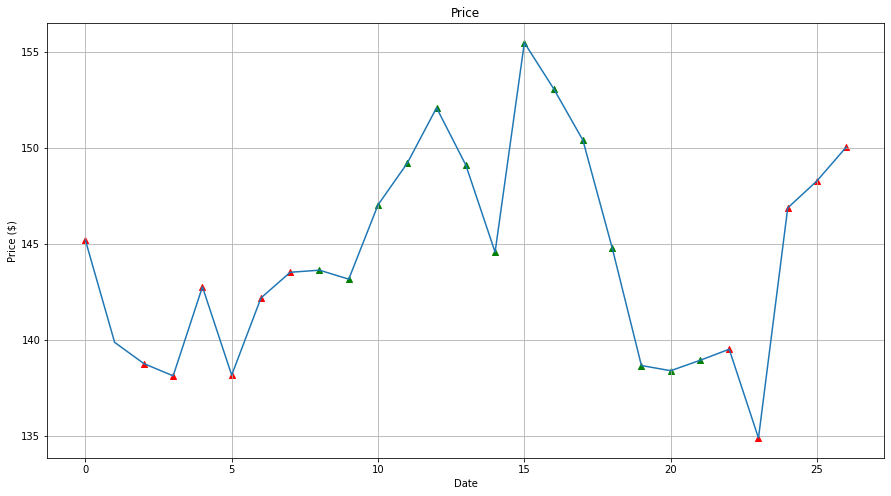

In [36]:
dummy_df = data_LSTM
# 그림 사이즈 설정
plt.figure(figsize=( 15,8))

# 종가 기준으로 차트를 그림
data_LSTM['Adj Close'].plot(grid=True)

# position이 1 인경우 초록색으로 해당 종가에 표시
plt.scatter(dummy_df.loc[data_LSTM.position == 1].index, dummy_df['Adj Close'][dummy_df.position == 1],
            color='green', 
            label='Buy', 
            marker = '^', 
            alpha=1)

# position이 -1 인경우 빨간색으로 해당 종가에 표시
plt.scatter(dummy_df.loc[dummy_df.position == 2].index, dummy_df['Adj Close'][dummy_df.position == 2],
            color='red', 
            label='Sell', 
            marker = '^', 
            alpha=1)

# # trend이 1 인경우 초록색으로 해당 종가에 표시
# plt.scatter(dummy_df.loc[df.trend == 1].index, dummy_df['Adj Close'][dummy_df.trend == 1],
#             color='pink', 
#             label='up', 
#             marker = 'o', 
#             alpha=0.5)

# # position이 -1 인경우 빨간색으로 해당 종가에 표시
# plt.scatter(dummy_df.loc[dummy_df.trend == 0].index, dummy_df['Adj Close'][dummy_df.trend == 0],
#             color='blue', 
#             label='down', 
#             marker = 'o', 
#             alpha=0.5)


plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.title('Price')

In [37]:
back_LSTM = backtest(data_LSTM,'position',True)

CAGR:  0.5101
Accumulated return: 0.0559
Average return:  0.0056
Benchmark return : 0.0109
Number of trades:  14
Number of win: 7
Hit ratio: 0.5
Investment period: 0.1095890410958904 yrs
Sharpe ratio: 26    1.151
Name: acc_rtn, dtype: float64
MDD: -5.230000000000001
Benchmark MDD: -13.260000000000005


In [38]:
dddddddddddd

NameError: name 'dddddddddddd' is not defined

## GRU

In [ ]:
model_path = f'./model_2021/GRU.h5'
checkpoint = ModelCheckpoint(filepath=model_path ,
                             monitor='val_accuracy',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

early_stopping = EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                              patience=20,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

In [ ]:
with tf.device("/gpu:0"):
    model_GRU = Sequential()
    model_GRU.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_GRU.add(Dense(128))
    model_GRU.add(Dropout(0.2))
    model_GRU.add(Dense(64))
    model_GRU.add(Dropout(0.2))
    model_GRU.add(Dense(32))
    model_GRU.add(Dropout(0.2))
    model_GRU.add(Dense(units = 3 ,  activation='softmax'))

    adam = optimizers.Adam(lr = 0.001)

    model_GRU.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                17664     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)               

In [ ]:
hist_GRU = model_GRU.fit(X_train, y_train
                  , batch_size= BATCH
                  , epochs= EPOCH # 
                  , validation_data=(X_test, y_test)
                  , callbacks= [checkpoint,early_stopping]
                 )

history_GRU = model_GRU.evaluate(X_test, y_test)

Epoch 1/100
316/321 [============================>.] - ETA: 0s - loss: 0.8912 - accuracy: 0.5644
Epoch 1: val_accuracy improved from -inf to 0.61538, saving model to ./model_2021\GRU.h5
321/321 [==============================] - 3s 5ms/step - loss: 0.8935 - accuracy: 0.5633 - val_loss: 0.7934 - val_accuracy: 0.6154
Epoch 2/100
315/321 [============================>.] - ETA: 0s - loss: 0.8438 - accuracy: 0.5959
Epoch 2: val_accuracy did not improve from 0.61538
321/321 [==============================] - 1s 4ms/step - loss: 0.8455 - accuracy: 0.5950 - val_loss: 0.8535 - val_accuracy: 0.6154
Epoch 3/100
315/321 [============================>.] - ETA: 0s - loss: 0.8421 - accuracy: 0.5948
Epoch 3: val_accuracy did not improve from 0.61538
321/321 [==============================] - 1s 4ms/step - loss: 0.8424 - accuracy: 0.5951 - val_loss: 0.9230 - val_accuracy: 0.6154
Epoch 4/100
316/321 [============================>.] - ETA: 0s - loss: 0.8373 - accuracy: 0.5975
Epoch 4: val_accuracy did no

KeyboardInterrupt: 

In [ ]:
# plt.style.use("grayscale")
# plt.figure(figsize=(20,10))
# plt.plot(hist.history["loss"], label="train_loss", color='b', marker='o')
# plt.plot(hist.history["val_loss"], label="val_loss", color='k', marker='o')
# plt.plot(hist.history["accuracy"], label="train_acc", color='r', marker='o')
# plt.plot(hist.history["val_accuracy"], label="val_acc", color='g', marker='o')
# plt.title("Training Loss and Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="upper right")


In [ ]:
pred_GRU = model_GRU.predict(X_test)
print(pred_GRU)
pp_GRU = np.argmax(pred_GRU, axis=-1)
pp_GRU.shape, y_test.shape

1/1 [==============================] - 0s 169ms/step
[[0.1519912  0.8293946  0.01861423]
 [0.21174638 0.7691127  0.0191409 ]
 [0.3324717  0.60887194 0.05865636]
 [0.22334376 0.75324786 0.02340846]
 [0.28964615 0.66293794 0.04741592]
 [0.18838783 0.78851616 0.02309601]
 [0.30157954 0.66153425 0.03688621]
 [0.4350061  0.43988907 0.12510483]
 [0.10630266 0.00971708 0.8839802 ]
 [0.30548    0.0313188  0.6632012 ]
 [0.40621892 0.10327985 0.49050128]
 [0.1659947  0.03286507 0.80114025]
 [0.17017873 0.04461795 0.7852033 ]]


((13,), (13, 1))

In [ ]:
history_GRU

[0.7916654348373413, 0.6153846383094788]

In [ ]:
f1_GRU = f1_score(y_test, pp_GRU, average='macro')
print(f"F1 score:{f1_GRU:.4f}")

F1 score:0.4571


In [ ]:
print(classification_report( y_test, pp_GRU, target_names=['holding','buy', 'sell']))

              precision    recall  f1-score   support

     holding       0.00      0.00      0.00         4
         buy       0.75      0.86      0.80         7
        sell       0.40      1.00      0.57         2

    accuracy                           0.62        13
   macro avg       0.38      0.62      0.46        13
weighted avg       0.47      0.62      0.52        13



In [ ]:
from sklearn.metrics import confusion_matrix
res_GRU = confusion_matrix(y_test, pp_GRU)
print(res_GRU)  

[[0 2 2]
 [0 6 1]
 [0 0 2]]


In [ ]:
len(pp_GRU)

13

In [ ]:
data_GRU = pd.DataFrame({"actual":data.iloc[int(len(data) - len(pp_GRU)):]["position"], "position":pp_GRU})

In [ ]:
data_GRU["Adj Close"] = data3["Adj Close"][int(len(data)) - len(pp_GRU):]

In [ ]:
data_GRU.reset_index(inplace=True)

In [ ]:
back_GRU = backtest(data_GRU,'position',True)

CAGR:  1.435
Accumulated return: 0.0747
Average return:  0.0153
Benchmark return : 0.0109
Number of trades:  8
Number of win: 4
Hit ratio: 0.5
Investment period: 0.052054794520547946 yrs
Sharpe ratio: 12    2.7775
Name: acc_rtn, dtype: float64
MDD: -3.420000000000001
Benchmark MDD: -13.260000000000005


## DNN

In [ ]:
model_path = f'./model_2021/DNN.h5'
checkpoint = ModelCheckpoint(filepath=model_path ,
                             monitor='val_accuracy',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

early_stopping = EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                              patience=20,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

In [ ]:
with tf.device("/gpu:0"):
    model_DNN = Sequential()
    model_DNN.add(Dense(128, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_DNN.add(Dense(256))
    model_DNN.add(Dropout(0.2))
    model_DNN.add(Dense(32))
    model_DNN.add(Dropout(0.2))
    model_DNN.add(Flatten())
    model_DNN.add(Dense(units = 3 ,  activation='softmax'))

    adam = optimizers.Adam(lr = 0.001)

    model_DNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model_DNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 20, 128)           3712      
                                                                 
 dense_6 (Dense)             (None, 20, 256)           33024     
                                                                 
 dropout_5 (Dropout)         (None, 20, 256)           0         
                                                                 
 dense_7 (Dense)             (None, 20, 32)            8224      
                                                                 
 dropout_6 (Dropout)         (None, 20, 32)            0         
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense_8 (Dense)             (None, 3)                

In [ ]:
hist_DNN = model_DNN.fit(X_train, y_train
                  , batch_size= BATCH
                  , epochs= EPOCH
                  , validation_data=(X_test, y_test)
                  , callbacks= [checkpoint, early_stopping]
                 )

history_DNN = model_DNN.evaluate(X_test, y_test)

Epoch 1/100
318/321 [============================>.] - ETA: 0s - loss: 0.9693 - accuracy: 0.5061
Epoch 1: val_accuracy improved from -inf to 0.61538, saving model to ./model_2021\DNN.h5
321/321 [==============================] - 2s 4ms/step - loss: 0.9694 - accuracy: 0.5060 - val_loss: 0.9855 - val_accuracy: 0.6154
Epoch 2/100
313/321 [============================>.] - ETA: 0s - loss: 0.9066 - accuracy: 0.5503
Epoch 2: val_accuracy improved from 0.61538 to 0.69231, saving model to ./model_2021\DNN.h5
321/321 [==============================] - 1s 4ms/step - loss: 0.9059 - accuracy: 0.5513 - val_loss: 0.9652 - val_accuracy: 0.6923
Epoch 3/100
316/321 [============================>.] - ETA: 0s - loss: 0.8952 - accuracy: 0.5585
Epoch 3: val_accuracy did not improve from 0.69231
321/321 [==============================] - 1s 4ms/step - loss: 0.8938 - accuracy: 0.5592 - val_loss: 1.2241 - val_accuracy: 0.6154
Epoch 4/100
312/321 [============================>.] - ETA: 0s - loss: 0.8948 - accu

In [ ]:
pred_DNN = model_DNN.predict(X_test)
print(pred_DNN)
pp_DNN = np.argmax(pred_DNN, axis=-1)
pp_DNN.shape, y_test.shape

1/1 [==============================] - 0s 62ms/step
[[0.06633105 0.9282692  0.00539981]
 [0.09543183 0.89857394 0.00599426]
 [0.14975311 0.83862865 0.01161815]
 [0.15414308 0.8307317  0.01512529]
 [0.13498665 0.8502823  0.01473112]
 [0.0745088  0.91991436 0.00557689]
 [0.14219637 0.8416254  0.01617823]
 [0.28729552 0.68032014 0.0323843 ]
 [0.38180825 0.05552986 0.5626619 ]
 [0.38489103 0.08288004 0.53222895]
 [0.4256822  0.18527961 0.38903823]
 [0.155868   0.01468485 0.82944715]
 [0.1302383  0.00546889 0.8642928 ]]


((13,), (13, 1))

In [ ]:
history_DNN

[1.013521432876587, 0.692307710647583]

In [ ]:
f1_DNN = f1_score(y_test, pp_DNN, average='macro')
print(f"F1 score:{f1_DNN:.4f}")

F1 score:0.6222


In [ ]:
print(classification_report( y_test, pp_DNN, target_names=['holding','buy', 'sell']))

              precision    recall  f1-score   support

     holding       1.00      0.25      0.40         4
         buy       0.75      0.86      0.80         7
        sell       0.50      1.00      0.67         2

    accuracy                           0.69        13
   macro avg       0.75      0.70      0.62        13
weighted avg       0.79      0.69      0.66        13



In [ ]:
from sklearn.metrics import confusion_matrix
res_DNN = confusion_matrix(y_test, pp_DNN)
print(res_DNN)  

[[1 2 1]
 [0 6 1]
 [0 0 2]]


In [ ]:
len(pp_DNN)

13

In [ ]:
data_DNN = pd.DataFrame({"actual":data.iloc[int(len(data) - len(pp_DNN)):]["position"], "position":pp_DNN})

In [ ]:
data_DNN["Adj Close"] = data3["Adj Close"][int(len(data)) - len(pp_DNN):]

In [ ]:
data_DNN.reset_index(inplace=True)

In [ ]:
data_DNN = backtest(data_DNN,'position',True)

CAGR:  1.4542
Accumulated return: 0.0757
Average return:  0.0196
Benchmark return : 0.0109
Number of trades:  8
Number of win: 3
Hit ratio: 0.375
Investment period: 0.052054794520547946 yrs
Sharpe ratio: 12    2.7891
Name: acc_rtn, dtype: float64
MDD: -3.420000000000001
Benchmark MDD: -13.260000000000005


In [ ]:
print(f'DNN:{np.min(hist_DNN.history["val_loss"]), np.max(hist_DNN.history["val_accuracy"])}')
print(f'LSTM:{np.min(hist_LSTM.history["val_loss"]), np.max(hist_LSTM.history["val_accuracy"])}')
print(f'GRU:{np.min(hist_GRU.history["val_loss"]), np.max(hist_GRU.history["val_accuracy"])}')

DNN:(0.8779996037483215, 0.692307710647583)
LSTM:(0.6956453323364258, 0.692307710647583)
GRU:(0.720035970211029, 0.692307710647583)


In [ ]:
print(np.mean(hist_DNN.history["val_accuracy"]))
print(np.mean(hist_LSTM.history["val_accuracy"]))
print(np.mean(hist_GRU.history["val_accuracy"]))

0.6538461744785309
0.6338461756706237
0.6346154063940048
